<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/karpathy-zero-to-hero/004-optimizing-neural-networks-initializations-activations-and-gradient-flow-part-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Neural Networks: Initializations, Activations, and Gradient Flow - Part 1

This notebook is a reconstruction of Andrej Karpathy's [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc). It covers:
- Initializing Neural Networks effectively for better training.
- Analyzing gradient flows to identify learning bottlenecks.
- Using [Batch Normalization](https://en.wikipedia.org/wiki/Batch_normalization) to stabilize gradients during training.

The notebook was broken into two parts because the lesson was a bit too long.

*The purpose of this notebook is for my own self-learning, and shouldn't add much to the original lesson beyond extra verbosity. Parts of the notebook, namely the code snippets, may have been copied from the source lesson verbatim.*

## Build the Dataset 🛠️📊

First, let's download a list of names:

In [55]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-09-13 15:56:51--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2024-09-13 15:56:51 (16.9 MB/s) - ‘names.txt.1’ saved [228145/228145]



And now parse them into a list:

In [56]:
words = open("names.txt", "r").read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

Let's assign a unique integer to each possible character found in the names we parsed:

In [57]:
# Create list with all unique characters found in the raw data (sorted alphabetically)
chars = sorted(list(set(''.join(words))))

# Create lookup table for converting each possible character to a unique integer
stoi_map = {s:i+1 for i,s in enumerate(chars)}
EOS_CHAR = "." # The character used to represent the end of a word
EOS_CHAR_INDEX = 0
stoi_map[EOS_CHAR] = EOS_CHAR_INDEX # Assign index zero to EOS char

# Create reverse lookup table
itos_map = {i:s for s,i in stoi_map.items()}
itos_map

# Count the size of the vocabulary
# (how many different characters exist in the dataset)
vocabulary_size = len(stoi_map)

len(stoi_map), stoi_map

(27,
 {'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0})

Now let's build a dataset where the inputs are sequences of $3$ characters and the outputs are the next predicted character. This dataset is then split into:

- **training set**: $80\%$ of the original dataset
- **validation set**: $10\%$ of the original dataset
- **test set**: $10\%$ of the original dataset

In [58]:
import torch
import random

# Set the RNG seed for reproducibility
SEED = 42
random.seed(SEED)

# The default number of characters to use to predict the next character
BLOCK_SIZE = 3

def build_dataset(words, block_size=BLOCK_SIZE, verbose=False):
  X, Y = [], [] # Initialize the dataset
  for word in words:
    if verbose: print(word)
    context = [0] * block_size # Initialize the context with EOS characters
    for char in word + EOS_CHAR: # For each character in the current word (plus the EOS stop character)
      X.append(context) # Add the context accumulated so far as the input
      char_i = stoi_map[char] # Convert the current character to an integer
      Y.append(char_i) # Add the current character as the output (previous context must predict current character)
      if verbose: print(f"{''.join([itos_map[i] for i in context])} => {char}")
      context = context[1:] + [char_i] # Update the context by popping out the oldest character and pushing in the current one (FIFO buffer)

  # Convert the dataset to tensors and return them
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

def build_split_dataset(words, block_size=BLOCK_SIZE):
  # Shuffle the words so that the data splits are random
  words = words.copy() # Copy so we don't modify the original reference when shuffling
  random.shuffle(words)

  # Split the dataset
  n1 = int(0.8 * len(words)) # First data split point
  n2 = int(0.9 * len(words)) # Second data split point
  training_set = build_dataset(words[:n1], block_size=block_size) # Create training set from range [0%-80%]
  validation_set = build_dataset(words[n1:n2], block_size=block_size) # Create validation set from range [80%-90%]
  test_set = build_dataset(words[n2:], block_size=block_size) # Create test set from range [90%-100%]

  # Return the splits
  return training_set, validation_set, test_set

# Create the dataset and split it into training, validation and test sets
training_set, validation_set, test_set = build_split_dataset(words)

# Output the number of examples in each dataset split
n_training_set = len(training_set[0])
n_validation_set = len(validation_set[0])
n_test_set = len(test_set[0])
n_total = n_training_set + n_validation_set + n_test_set
{
    "n_total" : n_total,
    "n_training" : n_training_set,
    "n_training_percentage" : round(n_training_set / n_total * 100),
    "n_validation" : n_validation_set,
    "n_validation_percentage" : round(n_validation_set / n_total * 100),
    "n_test" : n_test_set,
    "n_test_percentage" : round(n_test_set / n_total * 100)
}

{'n_total': 228146,
 'n_training': 182625,
 'n_training_percentage': 80,
 'n_validation': 22655,
 'n_validation_percentage': 10,
 'n_test': 22866,
 'n_test_percentage': 10}

Let's build the same model we used in the previous notebook:

In [59]:
def build_model(
    block_size=BLOCK_SIZE, # Number of previous characters used to predict the next character
    embedding_size=10, # Size of the dense vector used to represent each character
    n_hidden=200, # Number of neurons in the hidden layer
    init_scales={}, # Factor by which to scale the values in each parameter (ignore, to be used later in the notebook)
    extra_parameters=[], # Parameters to add to the model (ignore, to be used later in the notebook),
    statistics=[], # Model training statistics to be returned by the function (ignore, to be used later in the notebook)
    seed=SEED # The RNG seed to use when initializing parameters (for reproducibility)
):
  # Initialize the generator with the provided seed
  generator = torch.Generator().manual_seed(seed)

  # Create the embedding lookup table
  C = torch.randn((vocabulary_size, embedding_size), generator=generator) * init_scales.get('C', 1.0)

  # Create the weight matrix for the hidden layer
  W1 = torch.randn((embedding_size * block_size, n_hidden), generator=generator) * init_scales.get('W1', 1.0)

  # Create the biases for the hidden layer
  b1 = torch.randn(n_hidden, generator=generator) * init_scales.get('b1', 1.0)

  # Create the weight matrix for the output layer
  W2 = torch.randn((n_hidden, vocabulary_size), generator=generator) * init_scales.get('W2', 1.0)

  # Create the biases for the output layer
  b2 = torch.randn(vocabulary_size, generator=generator) * init_scales.get('b2', 1.0)

  # Create a list with all the parameters
  parameters = [C, W1, b1, W2, b2]
  for extra_param in extra_parameters: parameters.append(extra_param)

  # Enable gradient tracking for all model parameters
  for p in parameters: p.requires_grad = True

  return parameters, statistics

# Store a reference to the `build_model` function (ignore, to be used later in the notebook)
_build_model_1 = build_model

# Create the model
model = build_model()

# Unpack the model parameters
parameters, _ = model
C, W1, b1, W2, b2 = parameters

# Count the number of parameters
num_parameters = sum(p.nelement() for p in parameters)
print(f"Number of parameters: {num_parameters}")

Number of parameters: 11897


Now let's implement the training code:

      0/  10000: 25.019728


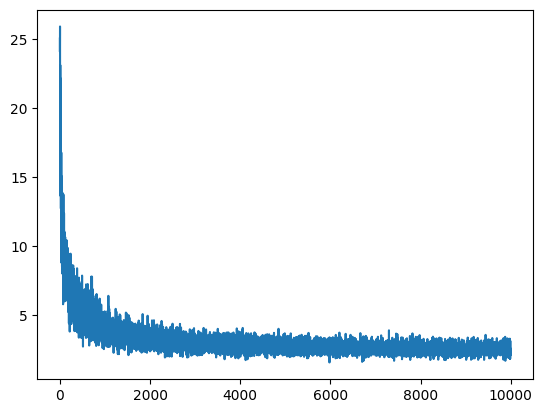

In [60]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(
    dataset, # The dataset to train on (a tuple with a list of inputs and a list of respective outputs)
    model, # The model parameters
    n_steps, # Train for N steps
    learning_rate=0.1, # The scale at which gradients should be applied to the parameters at each step
    batch_size=32, # The size of the mini-batch to randomly sample in each step
    log_steps=10_000, # How frequently should training progress be logged
    posthook_h_preact=None, # Code to execute right after the hidden layer's pre-activation has been calculated (ignore, to be used later in the notebook),
    seed=SEED # The RNG seed to use when sampling mini-batches (for reproducibility)
):
  # Initialize RNG for reproducibility
  generator = torch.Generator().manual_seed(seed)

  # Unpack the dataset
  X, Y = dataset

  # Unpack the model parameters
  parameters, _ = model
  C, W1, b1, W2, b2 = parameters[:5] # Making sure we unpack only 5 params for now (ignore, related to changes later in the notebook)

  # Train for N steps
  losses = []
  for step in range(n_steps):
    # Sample a mini-batch
    batch_indexes = torch.randint(0, X.shape[0], (batch_size,), generator=generator)
    Xbt, Ybt = X[batch_indexes], Y[batch_indexes]

    # Perform forward pass
    Xemb = C[Xbt] # Embed characters into vectors
    Xembcat = Xemb.view(Xemb.shape[0], -1) # Concatenate the vectors
    h_preact = Xembcat @ W1 + b1 # Hidden layer pre-activation
    h_preact = posthook_h_preact(h_preact) if posthook_h_preact else h_preact
    h = torch.tanh(h_preact) # Hidden layer activation
    logits = h @ W2 + b2 # Output layer activation
    loss = F.cross_entropy(logits, Ybt) # Calculate loss

    # Perform backpropagation
    for p in parameters: p.grad = None # Reset gradients from previous step
    loss.backward() # Perform backward pass

    # Perform gradient descent
    if learning_rate is None: learning_rate = learning_rate if step < n_steps * 0.9 else learning_rate / 10
    learning_rate = learning_rate() if callable(learning_rate) else learning_rate
    for p in parameters: p.data -= learning_rate * p.grad

    # Track stats
    if step % log_steps == 0: print(f"{step:7d}/{n_steps:7d}: {loss.item():4f}")
    losses.append(loss.item())

  # Return training losses and last step activations
  return {
      "losses" : losses,
      "Xemb" : Xemb,
      "Xembcat" : Xembcat,
      "h_preact" : h_preact,
      "h" : h,
      "logits" : logits
  }

# Store a reference to the function (we'll use this later
# in the notebook to extend the function's behavior)
_train_1 = train

# Train for 10k steps and plot losses
result = train(training_set, model, 10_000)
plt.plot(result["losses"])

Notice the "hockey stick" pattern in the loss curve early in training. This sharp drop happens because the model quickly adjusts biases, leading to fast initial gains.

To explain, imagine a linear function $y = a \times x + b$ separating two clusters. If the bias $b$ is poorly initialized, the loss is high because the line is far from the data. Adjusting $b$ moves the line closer, rapidly lowering the loss.

This issue stems from random initialization of the model's parameters. Proper initialization not only starts training with a lower loss but can also place the model in a better region of the loss surface.

By understanding our problem domain, we can improve parameter initialization. Without prior knowledge, the model's output should resemble a uniform distribution where each character has a probability of $1/27$ (since there are 27 characters in the vocabulary). With no prior training, the model has no preference, so all probabilities are equal, giving us the expected initial loss:

In [61]:
expected_initial_loss = -torch.tensor(1/27).log()
expected_initial_loss

tensor(3.2958)

The initial loss should be $3.2958$ rather than around $25$, like we're currently getting.

Before trying any optimizations, let's note down our current losses on the *training set* and *validation set* for later reference:

In [62]:
@torch.no_grad() # Don't track any gradients when running this function (we won't use this loss calculation to adjust the model parameters)
def calculate_dataset_split_loss(
    model, # The model whose loss we're evaluating
    split, # Dataset split to calculate the loss on
    posthook_h_preact=None # Function to run after the calculation of the pre-activations for the hidden layer (ignore for now, will used later in the notebook)
):
  # Unpack the model parameters
  parameters, _ = model
  C, W1, b1, W2, b2 = parameters[:5] # Unpack only the first 5 parameters (ignore, more parameters will be added later)

  # Retrieve the specified dataset split
  x, y = {
      "training" : training_set,
      "validation" : validation_set,
      "test" : test_set
  }[split]

  # Calculate the loss for the specified dataset split
  emb = C[x] # Fetch the embeddings for each character sequence
  embcat = emb.view(emb.shape[0], -1) # Concatenate the embeddings for each character sequence
  h_preact = embcat @ W1 + b1 # Forward pass through hidden layer
  h_preact = posthook_h_preact(h_preact) if posthook_h_preact else h_preact # Run hook if provided (ignore for now, will used later in the notebook)
  h = torch.tanh(h_preact) # Run activation on hidden layer pre-activations
  logits = h @ W2 + b2 # Forward pass through output layer to calculate the logits
  loss = F.cross_entropy(logits, y) # Calculate the loss

  # Print the loss for the specified dataset split
  print(f"{split}: {loss.item():.4f}")

# Store a reference to the original function so
# that we can extend it later in the notebook
_calculate_dataset_split_loss_1 = calculate_dataset_split_loss

# Calculate the losses for the training and validation sets
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

training: 2.5357
validation: 2.5471


We'll log the losses from different optimization experiments in this notebook to track what works and what doesn't. Let's record our first results:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |

## Manual Initialization - Output Layer 🎯📐

To manually calculate the loss for a uniform distribution at initialization, we need to see how the logits affect the loss.

Let's calculate the loss for a ground truth of $[0, 0, 1, 0]$ when all logits are set to $0.0$:

In [63]:
def _calc_probs_loss(logits):
  probs = F.softmax(logits, dim=0) # Perform softmax on the logits (same as exponentiating them, then normalizing them)
  loss = -probs[2].log() # Calculate the negative likelihood loss for the correct class when the ground truth is [0, 0, 1, 0]
  return logits, probs, loss
_calc_probs_loss(torch.tensor([0.0, 0.0, 0.0, 0.0])) # Feed sample 4-dimensional vector of logits

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

When all logits are $0.0$, the output distribution is uniform, resulting in a relatively low loss.

To boost the model's confidence in classifying index $2$ correctly, we can increase the magnitude of the corresponding logit:

In [64]:
_calc_probs_loss(torch.tensor([0.0, 0.0, 5.0, 0.0]))

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

Raising the logit for that position increases its probability while lowering the others. This reduces the loss, as the probability distribution is now closer to the expected output $[0, 0, 1, 0]$.

Let's calculate the loss for logits randomly sampled from a *standard normal distribution* (with a *mean* of $0.0$ and a *standard deviation* of $1.0$):

In [65]:
generator = torch.Generator().manual_seed(SEED) # Set RNG seed for reproducibility of this cell
for i in range(10):
  logits = torch.randn(4, generator=generator)  # Sample 4 random logits
  _, _, loss = _calc_probs_loss(logits)         # Calculate loss for expected output of [0, 0, 1, 0]
  print(f"logits: {logits}\t loss: {loss}")

logits: tensor([0.3367, 0.1288, 0.2345, 0.2303])	 loss: 1.387107014656067
logits: tensor([-1.1229, -0.1863,  2.2082, -0.6380])	 loss: 0.16977259516716003
logits: tensor([0.4617, 0.2674, 0.5349, 0.8094])	 loss: 1.388898491859436
logits: tensor([ 1.1103, -1.6898, -0.9890,  0.9580])	 loss: 2.8132131099700928
logits: tensor([ 1.3221,  0.8172, -0.7658, -0.7506])	 loss: 2.704949378967285
logits: tensor([ 1.3525,  0.6863, -0.3278,  0.7950])	 loss: 2.5012106895446777
logits: tensor([ 0.2815,  0.0562,  0.5227, -0.2384])	 loss: 1.0577948093414307
logits: tensor([-0.0499,  0.5263, -0.0085,  0.7291])	 loss: 1.7504920959472656
logits: tensor([ 0.1331,  0.8640, -1.0157, -0.8887])	 loss: 2.471569538116455
logits: tensor([ 0.1498, -0.2089, -0.3870,  0.9912])	 loss: 2.0635011196136475


The loss is low due to the small magnitude of the logits, let's scale them up by an order of magnitude:

In [66]:
generator = torch.Generator().manual_seed(SEED)      # Set RNG seed for reproducibility of this cell
for i in range(10):
  logits = torch.randn(4, generator=generator) * 10  # Sample 4 random logits (scaled up by 10)
  _, _, loss = _calc_probs_loss(logits)              # Calculate loss for expected output of [0, 0, 1, 0]
  print(f"logits: {logits}\t loss: {loss}")

logits: tensor([3.3669, 1.2881, 2.3446, 2.3033])	 loss: 1.6266359090805054
logits: tensor([-11.2286,  -1.8633,  22.0820,  -6.3800])	 loss: -0.0
logits: tensor([4.6166, 2.6735, 5.3490, 8.0936])	 loss: 2.8394775390625
logits: tensor([ 11.1029, -16.8980,  -9.8896,   9.5797])	 loss: 21.189725875854492
logits: tensor([13.2214,  8.1719, -7.6584, -7.5062])	 loss: 20.88612937927246
logits: tensor([13.5255,  6.8632, -3.2776,  7.9497])	 loss: 16.80811882019043
logits: tensor([ 2.8152,  0.5616,  5.2272, -2.3836])	 loss: 0.09489946812391281
logits: tensor([-0.4990,  5.2634, -0.0850,  7.2906])	 loss: 7.500233173370361
logits: tensor([  1.3314,   8.6398, -10.1567,  -8.8875])	 loss: 18.79719352722168
logits: tensor([ 1.4978, -2.0889, -3.8702,  9.9124])	 loss: 13.782815933227539


Losses can increase significantly because the softmax function exponentially amplifies differences between logits, causing one class to dominate with a much higher probability.

Further increasing the logit magnitudes can lead to positive infinities in the loss calculation:

In [67]:
generator = torch.Generator().manual_seed(SEED)       # Set RNG seed for reproducibility of this cell
for i in range(10):
  logits = torch.randn(4, generator=generator) * 100  # Sample 4 random logits (scaled up by 100)
  _, _, loss = _calc_probs_loss(logits)               # Calculate loss for expected output of [0, 0, 1, 0]
  print(f"logits: {logits}\t loss: {loss}")

logits: tensor([33.6690, 12.8809, 23.4462, 23.0333])	 loss: 10.222861289978027
logits: tensor([-112.2856,  -18.6328,  220.8201,  -63.7997])	 loss: -0.0
logits: tensor([46.1657, 26.7351, 53.4905, 80.9357])	 loss: 27.445255279541016
logits: tensor([ 111.0290, -168.9799,  -98.8960,   95.7972])	 loss: inf
logits: tensor([132.2135,  81.7190, -76.5839, -75.0622])	 loss: inf
logits: tensor([135.2548,  68.6322, -32.7759,  79.4969])	 loss: inf
logits: tensor([ 28.1520,   5.6164,  52.2716, -23.8357])	 loss: -0.0
logits: tensor([-4.9903, 52.6337, -0.8499, 72.9061])	 loss: 73.75594329833984
logits: tensor([  13.3142,   86.3978, -101.5675,  -88.8749])	 loss: inf
logits: tensor([ 14.9780, -20.8894, -38.7021,  99.1238])	 loss: inf


Now let's investigate the cause of the loss calculation error by inspecting one of the examples that resulted in infinity:

In [68]:
import math

generator = torch.Generator().manual_seed(SEED)       # Set RNG seed for reproducibility of this cell (reliably repro infinity issue)
for i in range(10):
  logits = torch.randn(4, generator=generator) * 100  # Sample 4 random logits (scaled up by 100)
  _, probs, loss = _calc_probs_loss(logits)           # Calculate loss for expected output of [0, 0, 1, 0]
  if math.isinf(loss.item()): break                   # Break when we detect an infinity in the loss (to inspect that example)

# Inspect example with infinity in loss
{
    "logits" : logits,
    "probs" : probs,
    "loss" : loss
}

{'logits': tensor([ 111.0290, -168.9799,  -98.8960,   95.7972]),
 'probs': tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 2.4260e-07]),
 'loss': tensor(inf)}

The reason we're getting $\infty$ can be explained step by step:

1. **Large logit at index 0:**  
   The logit at index $0$ is much larger than the other logits.

2. **Softmax exponentiation:**  
   Softmax exponentiates each logit to ensure positivity. The large logit at index $0$ results in a huge value, while the others remain much smaller.

3. **Softmax normalization:**  
   The exponentiated values are divided by their sum, making the probability at index $0$ approach $1.0$ and the others (like index $2$) near $0.0$.

4. **Negative log-likelihood calculation:**  
   Calculating the loss for index $2$ gives $\log(0) = -\infty$.

5. **Final result:**  
   Negating $-\infty$ results in $\infty$ for the loss.

Thus, we need to keep logits within a narrower range to prevent this imbalance while maintaining the distribution.

Let's run training for one step and inspect the current logits:




In [69]:
model = build_model()
result = train(training_set, model, 1)
logits = result["logits"]
logits[0]

      0/      1: 25.019728


tensor([ 17.9819,  -3.6784,  24.2404,  -3.1846,  -9.5619,  17.6615,  -7.9963,
          8.0883,  -6.5596,   0.8169,   1.0460,  -4.9865,  -4.5982,  15.5030,
         10.0235,   2.7803,   2.5039,  33.4953,   5.1201,  -9.4040,  14.3373,
        -23.3758,  10.4525,  -9.3290,   6.1106,  10.4929,  -2.1683],
       grad_fn=<SelectBackward0>)

The logits we're getting are too large, which causes one logit to dominate and the others to be ignored. To fix this, we need to reduce their magnitude.

Since `logits = h @ W2 + b2`, we can scale down both `W2` and `b2`. The bias `b2` just shifts the values, so we can set it to $0.0$ to eliminate it. Then, we can reduce `W2` by multiplying it by $0.01$ to lower the activations from `h` by two orders of magnitude:

In [70]:
model = build_model(init_scales={"W2": 0.01, "b1": 0.0}) # Scale down `W2` weights and set `b2` biases to zero
result = train(training_set, model, 1) # Train for 1 epoch
initial_loss = result["losses"][0]
initial_loss, expected_initial_loss

      0/      1: 4.207558


(4.207557678222656, tensor(3.2958))

We're now seeing a much better loss at the start of training, likely because the logits are constrained to a narrower range:

In [71]:
result["logits"][0]

tensor([-1.0148, -1.4639,  1.0138, -0.3878, -0.0253,  1.1731, -0.3383, -0.4993,
        -0.8297, -0.0373, -0.8045, -0.3324, -1.0605, -1.7245, -0.0197,  1.9198,
        -1.4889,  2.1038,  0.9187,  1.9497,  1.1492, -0.3888, -0.1203,  0.1977,
         1.0747,  0.3552,  1.3495], grad_fn=<SelectBackward0>)

All the logits are within a narrow range as expected, resulting in a more uniform output distribution at initialization. This matches our expected distribution and produces a loss value close to what we anticipated.

To get an even more accurate result, we could further scale the weights down toward zero:

In [72]:
model = build_model(init_scales={"W2": 0.00, "b2" : 0.0}) # Cancel out all signal coming from the hidden layer
result = train(training_set, model, 1) # Train for 1 step
initial_loss = result["losses"][0]
initial_loss, expected_initial_loss

      0/      1: 3.295837


(3.295837163925171, tensor(3.2958))

The initial loss now perfectly matches our expected value! This is because when all the logits are zero, they produce a perfectly uniform distribution, which aligns with the expected initial loss. Let's do a quick check to confirm that the logits are indeed zero:

In [73]:
result["logits"][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward0>)

Setting logits to zero was just an educational example. Initializing weights to zero would make all gradients identical, preventing effective learning.

Let's train again with `W2` scaled down by $0.01$, `b2` set to $0.0$, and measure the results of a long training run:

In [74]:
model = build_model(init_scales={"W2": 0.01, "b2" : 0.0})
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.276392
  10000/  50000: 2.084972
  20000/  50000: 2.400868
  30000/  50000: 2.323374
  40000/  50000: 2.052799
training: 2.2408
validation: 2.2859


Both losses have improved since we avoided wasting initial steps on adjusting biases. Let's add this result to the benchmarks:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |

## Manual Initialization - Hidden Layer 🧩📐

Now that we've fixed the initial activation of the output layer, let's inspect the initial activation of the hidden layer:

In [75]:
h = result["h"]
h

tensor([[ 1.0000,  1.0000,  0.9990,  ...,  0.9970,  0.4608,  0.8696],
        [ 0.9996,  1.0000,  0.5923,  ..., -1.0000, -0.9999, -1.0000],
        [-1.0000,  0.9999, -1.0000,  ...,  1.0000,  0.9689,  0.9994],
        ...,
        [ 0.9996,  1.0000,  0.5923,  ..., -1.0000, -0.9999, -1.0000],
        [-0.9999,  1.0000, -0.9994,  ...,  0.8569, -0.9915,  1.0000],
        [ 1.0000,  1.0000, -0.9965,  ..., -0.9750, -0.7983,  1.0000]],
       grad_fn=<TanhBackward0>)

One noticeable pattern is that many values are near $-1$ or $1$, which makes sense as this layer's output passes through the $\tanh$ function.

Let's review how the $\tanh$ function behaves:

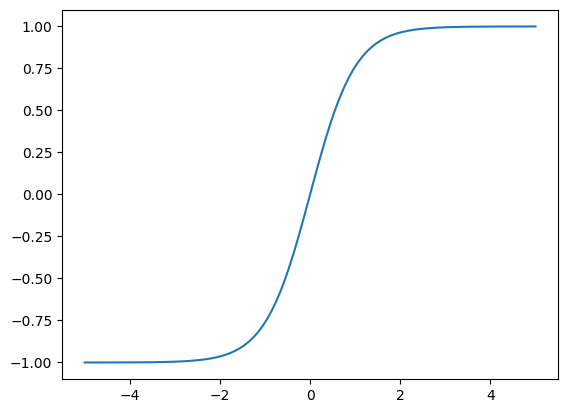

In [76]:
x = torch.linspace(-5, 5, 100)
y = torch.tanh(x)
plt.plot(x, y)

When $x < -2$ or $x > 2$, the $\tanh$ function flattens, causing the gradient to become $0.0$ (since $y$ remains unchanged with small changes in $x$).

Since gradients propagate backward through the network using the chain rule, if one layer has a zero gradient, earlier layers also stop updating. This makes it difficult or even impossible for earlier layers to learn, leading to slower or halted learning. This is known as the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), which is especially common in deeper networks. As a result, training can slow down significantly or fail to converge within a practical time frame.

Let's visualize the activations of the hidden layer with a histogram.

First, let's check its shape:

In [77]:
h.shape

torch.Size([32, 200])

We need to flatten it first:

In [78]:
h.view(-1).shape

torch.Size([6400])

And then convert it to a regular list:

In [79]:
h.view(-1).tolist()[:4]

[0.9999998211860657, 1.0, 0.9990352988243103, -0.9999982714653015]

Now, let's plot a histogram with the values distributed into $50$ bins:

(array([2257.,  142.,  116.,   66.,   54.,   48.,   37.,   48.,   19.,
          39.,   22.,   16.,   25.,   22.,   29.,   28.,   23.,   26.,
          10.,   17.,   17.,   17.,   12.,   23.,   11.,   16.,   23.,
          19.,   22.,   16.,   20.,   22.,   25.,   11.,   17.,   16.,
          24.,   30.,   26.,   37.,   29.,   27.,   33.,   52.,   35.,
          55.,   75.,  103.,  154., 2389.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

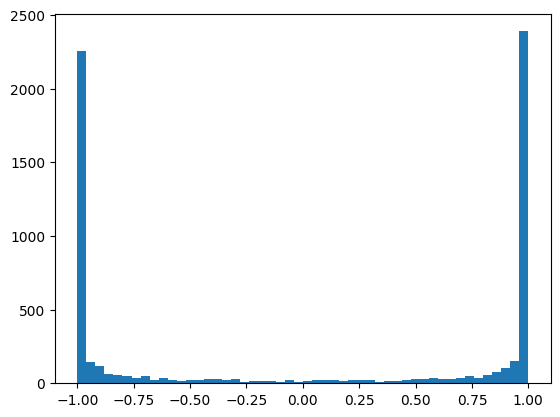

In [80]:
plt.hist(h.view(-1).tolist(), 50)

Most activations are $-1$ or $1$, which are in the flat regions of $\tanh$ where gradients are very small, this makes it hard for the network to update weights and learn effectively.

To understand which data samples are triggering this issue in specific neurons, let's plot all `h` activations (the $\tanh$ outputs) with a magnitude greater than $0.99$, indicating they are at the extremes of the $\tanh$ function:

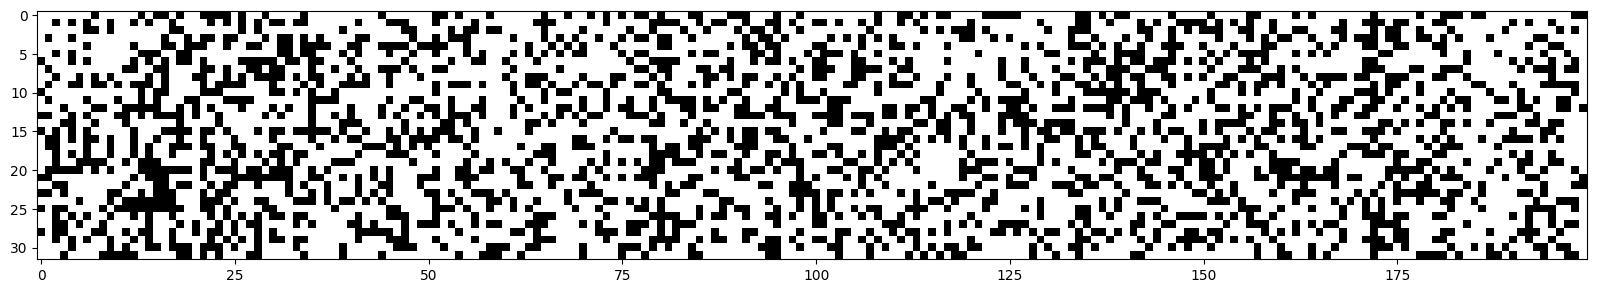

In [81]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray")

In the plot above, the $Y$ axis shows $30$ mini-batch inputs, and the $X$ axis represents $200$ hidden layer neurons.

White pixels indicate saturated $\tanh$ activations (magnitude is bigger than $0.99$), while black pixels show non-saturated activations.

A fully white column would indicate a "dead" neuron, where all inputs lead to zero gradients. This would prevent the neuron from learning and disrupt gradient flow to earlier layers, slowing their learning.

Fortunately, there are no fully white columns, so all neurons are learning from at least some inputs. However, most neurons are saturated, meaning many inputs produce extreme activations, resulting in small gradients and minimal learning. Reducing saturation would improve gradient flow and accelerate learning, especially early in training.

---

Let's examine the distribution of values in the hidden layer pre-activations
(the values fed to the $\tanh$ function):

(array([  3.,   3.,   9.,  14.,  13.,  18.,  25.,  41.,  66.,  87.,  72.,
        108., 113., 143., 189., 212., 229., 241., 306., 335., 388., 411.,
        388., 417., 351., 327., 291., 261., 269., 216., 168., 176., 110.,
         82.,  72.,  60.,  50.,  28.,  39.,  17.,   5.,  24.,  10.,   5.,
          2.,   1.,   2.,   0.,   0.,   3.]),
 array([-19.89199448, -18.99953369, -18.10707291, -17.21461212,
        -16.32215134, -15.42969055, -14.53722977, -13.64476898,
        -12.7523082 , -11.85984741, -10.96738663, -10.07492584,
         -9.18246506,  -8.29000427,  -7.39754349,  -6.5050827 ,
         -5.61262192,  -4.72016113,  -3.82770035,  -2.93523956,
         -2.04277878,  -1.15031799,  -0.25785721,   0.63460358,
          1.52706436,   2.41952515,   3.31198593,   4.20444672,
          5.0969075 ,   5.98936829,   6.88182907,   7.77428986,
          8.66675064,   9.55921143,  10.45167221,  11.344133  ,
         12.23659378,  13.12905457,  14.02151535,  14.91397614,
         15.806436

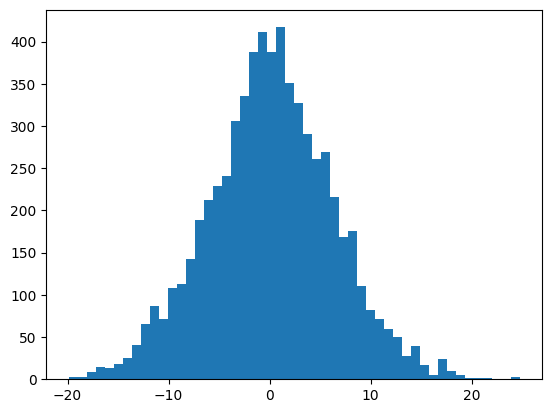

In [82]:
h_preact = result["h_preact"]
plt.hist(h_preact.view(-1).tolist(), 50)

The wide range of pre-activations explains why $\tanh$ becomes saturated at the extremes. Values outside $[-2, 2]$ are squashed to $-1$ or $1$, where the gradient is zero. Since most values fall between $[-20, 20]$, the majority are compressed into these extremes, resulting in zero gradient and no learning from those inputs.

By scaling down the hidden layer pre-activation values by an order of magnitude, they would more often fall within $[-2, 2]$, avoiding $\tanh$ saturation, resulting in larger gradients, and therefore improving learning:

(array([  3.,   3.,   9.,  14.,  13.,  18.,  25.,  41.,  66.,  87.,  72.,
        108., 113., 143., 189., 212., 229., 241., 306., 335., 388., 411.,
        388., 417., 351., 327., 291., 261., 269., 216., 168., 176., 110.,
         82.,  72.,  60.,  50.,  28.,  39.,  17.,   5.,  24.,  10.,   5.,
          2.,   1.,   2.,   0.,   0.,   3.]),
 array([-1.98919952, -1.89995344, -1.81070736, -1.72146128, -1.6322152 ,
        -1.54296912, -1.45372304, -1.36447696, -1.27523088, -1.1859848 ,
        -1.09673872, -1.00749264, -0.91824656, -0.82900048, -0.7397544 ,
        -0.65050832, -0.56126224, -0.47201616, -0.38277008, -0.293524  ,
        -0.20427792, -0.11503184, -0.02578576,  0.06346032,  0.1527064 ,
         0.24195248,  0.33119856,  0.42044464,  0.50969072,  0.5989368 ,
         0.68818288,  0.77742896,  0.86667504,  0.95592112,  1.0451672 ,
         1.13441328,  1.22365936,  1.31290544,  1.40215152,  1.4913976 ,
         1.58064368,  1.66988976,  1.75913584,  1.84838192,  1.937628  ,
 

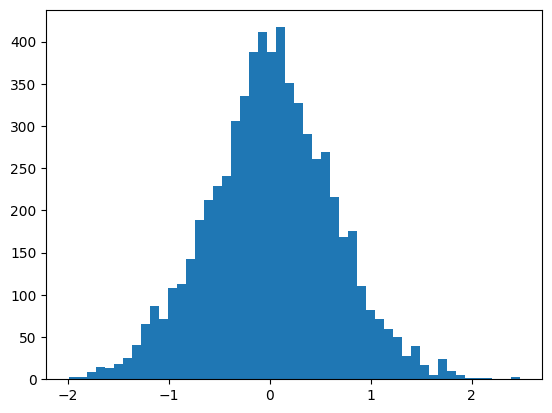

In [83]:
h_preact = result["h_preact"] * 0.1
plt.hist(h_preact.view(-1).tolist(), 50)

The hidden layer pre-activations are now all in a safe range, so most values will not fall into the extremes of the $tanh$ anymore.

Let's apply this scaling factor to the hidden layer's weights `W1` and check what happens to its activations as a result:

      0/      1: 3.294898


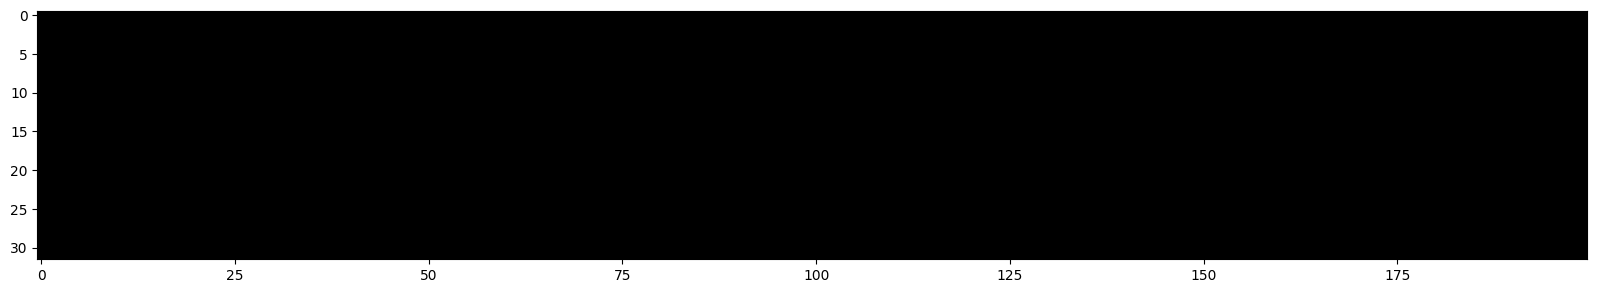

In [84]:
model = build_model(init_scales={"W1": 0.1, "b1" : 0.01, "W2": 0.01, "b2" : 0.0})
result = train(training_set, model, 1)
h = result["h"]
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray")

All pixels are black, meaning no hidden layer activations are falling into the flat regions of the $\tanh$ function. This indicates that gradients are being calculated for every neuron, allowing the entire network to learn from each example during the early stages of training.

Let's do a long training run with these parameters:

In [85]:
model = build_model(init_scales={"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0})
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.294705
  10000/  50000: 2.262302
  20000/  50000: 2.428632
  30000/  50000: 2.250552
  40000/  50000: 1.943440
training: 2.1586
validation: 2.1903


The resulting loss has improved again! Let's update our benchmark table with the results:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |

While initializing the weights to prevent any $\tanh$ activation may work, it might be better to enable the model to use some non-linear expressivity from the start. Let's slightly increase the `W1` weights to allow some inputs to saturate the $\tanh$, and add a small bias to `b1` for similar reasons:

      0/      1: 3.290241


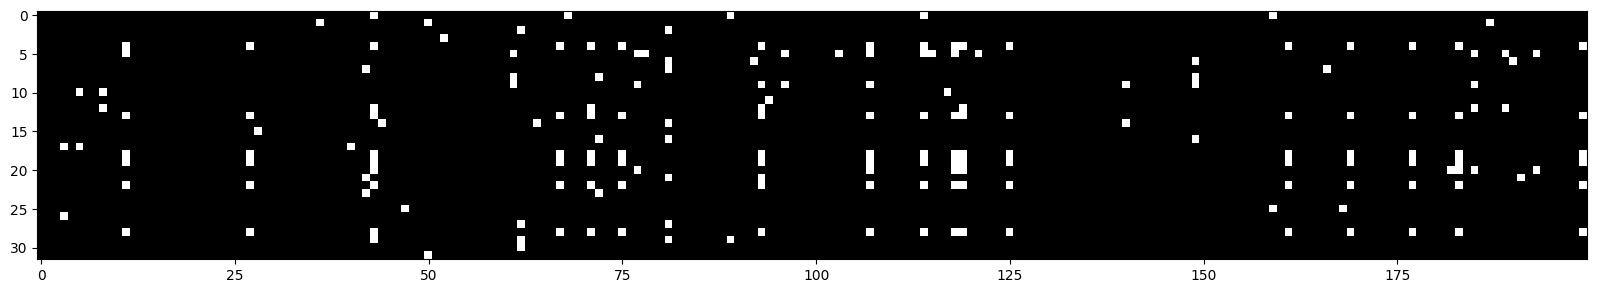

In [86]:
model = build_model(init_scales={"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0})
result = train(training_set, model, 1)
h = result["h"]
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray")

Now let's do another run:

In [87]:
model = build_model(init_scales={"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0})
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.290241
  10000/  50000: 2.190086
  20000/  50000: 2.365613
  30000/  50000: 2.217246
  40000/  50000: 2.029909
training: 2.1584
validation: 2.1963


The results were slightly worse, but very similar. They could have been better, depending on the problem and the randomness involved. The key idea remains: striking a balance between ensuring some non-linear expressivity at initialization while avoiding saturating the activations to maintain gradient flow. Let's log the experiment result:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.1584          |  2.1963            |

## Kaiming Initialization 🚀🔧

Manual weight initialization can be tedious and error-prone, especially as networks grow more complex. [Kaiming Initialization](https://paperswithcode.com/method/he-initialization) simplifies this process by providing formulas to set initial weights that help maintain stable gradients during training. Let's explore how this method works and apply it to our model.

We'll start with a simple example by simulating a forward pass through a layer (without bias or non-linear activation) and analyze how the input distributions affect the output distributions:

X - mean: -0.0032, std: 1.0052
Y - mean: 0.0044, std: 3.0927


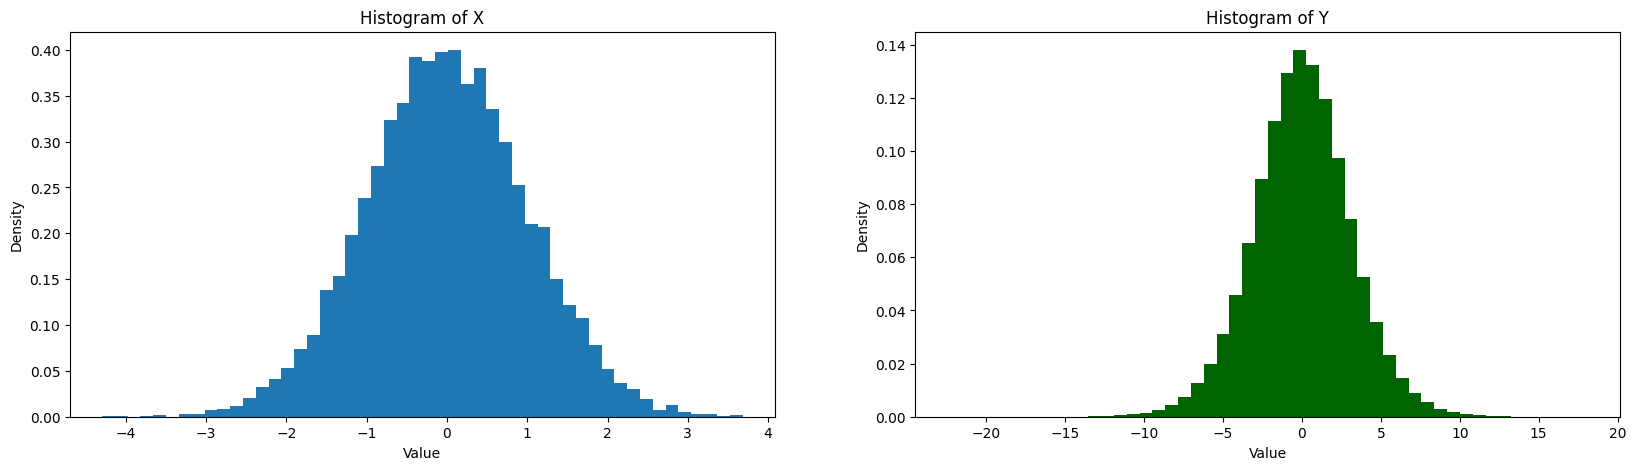

In [88]:
import torch
import matplotlib.pyplot as plt

def _test_activations(init_scales = {}):
    # Generate an input tensor of 1000 inputs with 10 values each
    x = torch.randn(1000, 10) * init_scales.get('x', 1.0)

    # Generate a weight matrix that stores the weights for the
    # 10 values in each input to be forwarded to 200 neurons
    w = torch.randn(10, 200) * init_scales.get('w', 1.0)

    # Perform forward pass
    y = x @ w

    # Print the statistics of the inputs and outputs
    print(f"X - mean: {x.mean():.4f}, std: {x.std():.4f}")
    print(f"Y - mean: {y.mean():.4f}, std: {y.std():.4f}")

    # Plot an histogram for X (50 bins)
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.hist(x.view(-1).tolist(), 50, density=True)
    plt.title('Histogram of X')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Plot an histogram for Y (50 bins) with dark green color
    plt.subplot(122)
    plt.hist(y.view(-1).tolist(), 50, density=True, color='darkgreen')
    plt.title('Histogram of Y')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Display the plots
    plt.show()

_test_activations()

The left plot shows the histogram for tensor $X$, which follows a *standard normal distribution* with a *mean* of $0.0$ ($\mu=0$) and a *standard deviation* of $1.0$ ($\sigma=1$).

The right plot shows the histogram for tensor $Y$, which is also a *normal distribution* with a *mean* of $0.0$ ($\mu=0$), but with a *standard deviation* of $3$ ($\sigma=3$).

Now, let's see what happens when we scale up the values of `w`:

X - mean: 0.0143, std: 0.9924
Y - mean: 0.0025, std: 15.8297


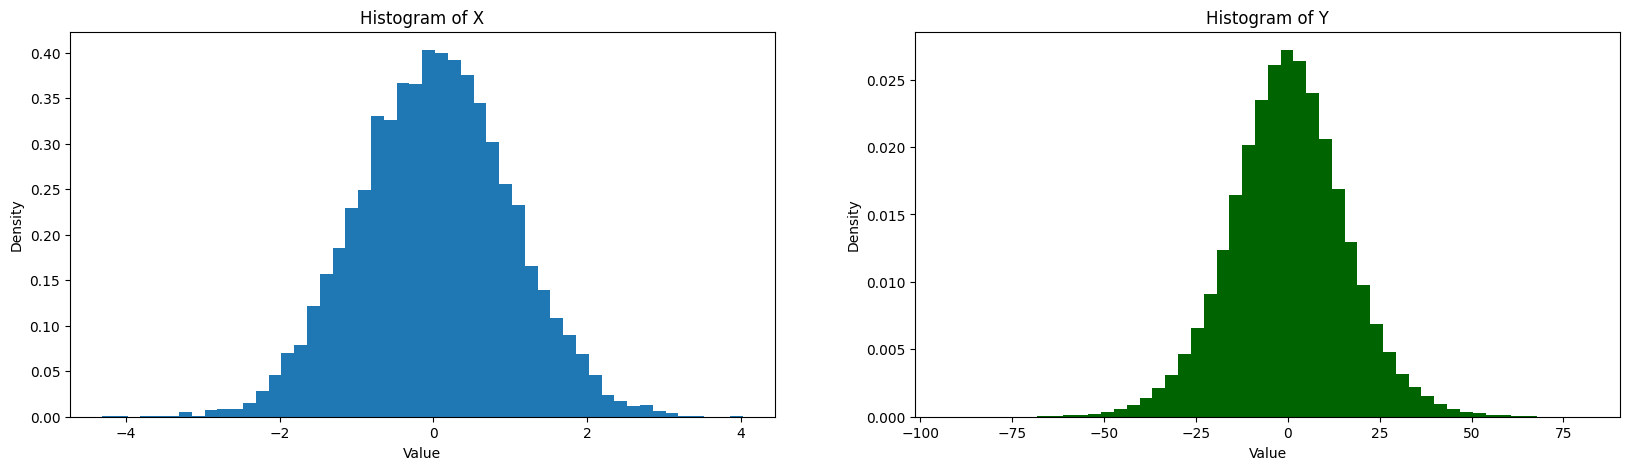

In [89]:
_test_activations({'w' : 5})

Scaling the weights by $5.0$ increased the *standard deviation* of $Y$ from $3$ to $16$ ($\mu=0$, $\sigma=16$).

Now, let's scale down `w`:

X - mean: -0.0084, std: 1.0022
Y - mean: -0.0000, std: 0.3245


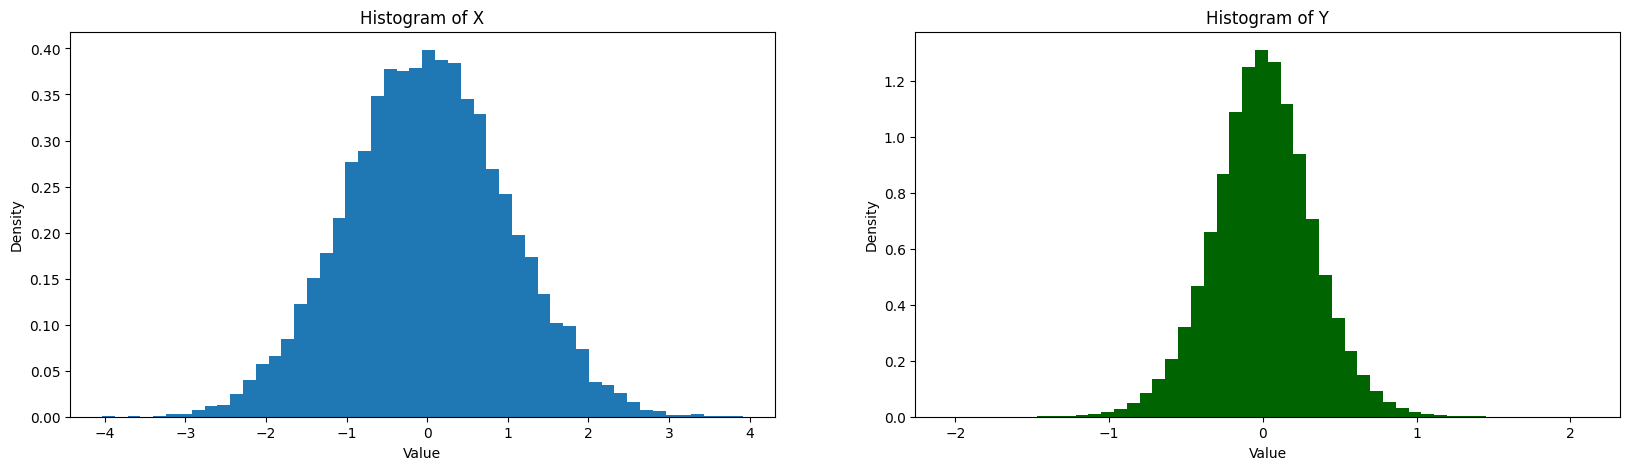

In [90]:
_test_activations({'w' : 0.1})

Scaling down the weights by $0.1$ decreased the *standard deviation* of $Y$ from $3$ to $0.3$ ($\mu=0$, $\sigma=0.3$).

Now that we understand how scaling affects the *standard deviation*, the question is: what value will make $Y$ have a *standard deviation* of $1.0$ ($\mu=0$, $\sigma=1$)?

The answer is to divide the weights by the square root of the *fan-in*, which is the first dimension of the tensor. Since the shape of the tensor `w` is $(10, 200)$, its *fan-in* is $10$, so we need to divide all the tensor values by $\sqrt{10}$.

X - mean: 0.0013, std: 1.0020
Y - mean: 0.0007, std: 0.9946


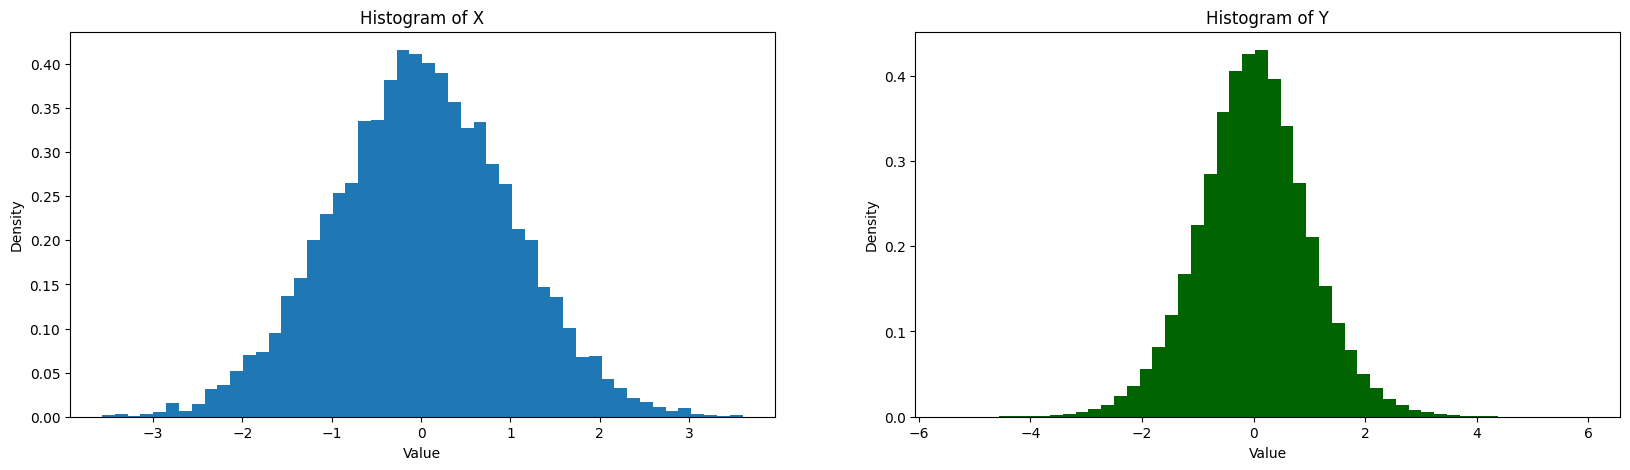

In [91]:
_test_activations({'w' : 1 / 10**0.5}) # square root of 10 is the same as pow(10, 0.5); also multiplying by 1/10**0.5 is the same as dividing by 10**0.5

We now know how to initialize the model's parameters so that the layer outputs follow a *standard normal distribution* ($\mu=0$, $\sigma=1$), reducing the risk of vanishing or exploding gradients.

*Kaiming Initialization* improves on this by specifying different gains for each non-linearity. For example, $tanh$ progressively compresses values, so multiplying weights by a gain can counteract this effect.

However, precise initialization is less critical now, thanks to techniques like [Batch Normalization](https://paperswithcode.com/method/batch-normalization), [Residual Connections](https://paperswithcode.com/method/residual-connection), and optimizers like [Adam](https://paperswithcode.com/method/adam), which help networks overcome imperfect initialization.

Therefore, dividing the weights by the square root of the layer's fan-in is a solid starting point.

Let's update the `build_model()` method for proper initialization and retrain:

In [92]:
import inspect
from functools import wraps

# Applies the default kwargs from the specified function
# into the provided kwargs (for undefined values); we'll
# require this to be able to redefine the behavior of
# the build_model() function (and others) without fully
# re-implementing it (see below)
def apply_kwargs_defaults(func, kwargs):
    # Get the default argument values for the function
    signature = inspect.signature(func)
    default_kwargs = {
        k: v.default
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }
    # Update default kwargs with provided kwargs
    default_kwargs.update(kwargs)
    return default_kwargs

# Redefine build_model() without rewriting the whole function.
# We just change the keyword arguments and call the original function.
def build_model(*args, init_gain=1, **kwargs):
  # Apply the defaults from the original build_model function
  kwargs = apply_kwargs_defaults(_build_model_1, kwargs)

  # Calculate the proper scales for each layer
  # and set them in the keyword arguments
  embedding_size = kwargs["embedding_size"]
  n_hidden = kwargs["n_hidden"]
  block_size = kwargs["block_size"]
  kwargs["init_scales"] = {
      "C" : 1.0 / (vocabulary_size ** 0.5),
      "W1" : init_gain / ((embedding_size * block_size) ** 0.5),
      "b1" : 1.0 / (n_hidden ** 0.5),
      "W2" : init_gain / (n_hidden ** 0.5),
      "b2" : 1.0 / (vocabulary_size ** 0.5)
  }

  # Invoke the original build_model function
  # with the updated keyword arguments
  return _build_model_1(*args, **kwargs)

# Store the reference of this new build_model()
# version so we can extend it further later on
_build_model_2 = build_model

# Calculate the initial training loss and compare it to our target
model = build_model()
result = train(training_set, model, 1)
initial_loss = result["losses"][0]
initial_loss, expected_initial_loss

      0/      1: 3.427603


(3.427603244781494, tensor(3.2958))

Notice how, without any manual adjustments, we achieved an initial loss very close to the expected value for a perfect uniform probability distribution at initialization.

Now, let's run a long training session and observe the results:

In [93]:
model = build_model()
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.427603
  10000/  50000: 2.375229
  20000/  50000: 2.432935
  30000/  50000: 2.204496
  40000/  50000: 1.993320
training: 2.1782
validation: 2.2021


Although these aren't the best results so far, they're much better than an uninitialized model.

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |
| `{"W1": 0.2, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1594          |  2.1979            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.1584           |  2.1963          |
| Kaiming Initialization (without gain)       |  2.1782           |  2.2021            |


But what if we followed the paper exactly and applied the correct gain for the non-linearity we're using, $\tanh$?

In [94]:
import math

# Redefine build_model() without rewriting the whole function.
# We just change the keyword arguments and call the original function.
def build_model(*args, **kwargs):
    # Apply the defaults from the original build_model function
    kwargs = apply_kwargs_defaults(_build_model_1, kwargs)

    # Apply gain factor for tanh based
    # on Kaiming Init paper recommendation
    tanh_gain = 5 / 3
    kwargs["init_gain"] = tanh_gain

    # Invoke the original build_model function
    # with the updated keyword arguments
    return _build_model_2(*args, **kwargs)

# Store the reference of this new build_model()
# version so we can extend it further later on
_build_model_3 = build_model

# Calculate the initial training loss and compare it to our target
model = build_model()
result = train(training_set, model, 1)
initial_loss = result["losses"][0]
initial_loss, expected_initial_loss

      0/      1: 3.544665


(3.5446648597717285, tensor(3.2958))

The initial loss isn't as good as it was without the gain. Let's set that aside and run a long training session to see the final outcome:

In [95]:
model = build_model()
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.544665
  10000/  50000: 2.383607
  20000/  50000: 2.466025
  30000/  50000: 2.272717
  40000/  50000: 1.975847
training: 2.1696
validation: 2.1977


Using proper initialization gave us the best results so far, but they aren't significantly different from not applying the gain. This reinforces the idea that skipping the gain is likely good enough while being simpler. Let's log the outcome of this experiment:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |
| `{"W1": 0.2, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1594          |  2.1979            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.1584           |  2.1963          |
| Kaiming Initialization (without gain)       |  2.1782           |  2.2021            |
| Kaiming Initialization (with $tanh$ gain)       |  2.1696          |   2.1977            |


## Batch Normalization ⚙️📏

Even with proper initialization, neural networks can have unstable training due to fluctuating activation distributions. Batch Normalization addresses this by normalizing pre-activations, leading to faster convergence and better performance.

We want the hidden layer pre-activations to be roughly normal—neither too low (to avoid under-activating $\tanh$) nor too high (to avoid saturating it).

Let's apply this to the `h_preact` tensor and first check its shape:

In [96]:
h_preact = result["h_preact"]
h_preact.shape

torch.Size([32, 200])

The `h_preact` tensor contains activations for $32$ examples from the mini-batch, propagated to $200$ neurons in the hidden layer. To normalize these activations, we'll calculate the mean across each example's rows, resulting in a tensor of shape $(1, 200)$:

In [97]:
h_preact.mean(0, keepdim=True).shape, h_preact.mean(0, keepdim=True)

(torch.Size([1, 200]),
 tensor([[ 0.5054,  0.1299, -0.1330, -0.0058, -0.8016, -0.2010,  0.0056,  0.1707,
          -0.3012,  0.4277,  0.3122, -0.2107,  0.3962, -0.3493,  1.1691,  0.2888,
          -0.1592,  0.0426, -0.1716, -0.7665, -0.0756, -0.1291, -0.3633, -0.1604,
           0.2597,  0.4800,  0.2269, -0.0887,  0.6783, -0.3219,  0.2792, -0.2367,
           0.2121, -0.0894, -0.2116, -0.6583,  1.1220, -0.7861, -0.2389, -0.2466,
          -0.3013,  0.0988,  0.3214, -0.4488,  0.1489,  0.4595,  0.0811,  0.4243,
           0.4313, -0.3156,  0.6376,  0.0057, -0.2650, -0.3665,  0.3177, -0.3037,
           0.4737,  0.1357,  0.2952, -0.2821,  0.5165,  0.4213, -1.2157,  0.1839,
           0.0394, -0.4026,  0.0873,  0.4416,  0.4015,  0.0919, -0.3484,  0.2952,
           0.3902, -0.3297,  0.2275, -0.4024, -0.0472,  0.0750,  0.1438, -0.4120,
          -0.4320, -0.0067, -0.1962,  0.9684,  0.3712,  0.0859,  0.0261, -0.2596,
          -0.4837,  0.5147, -0.1544,  0.0635, -0.0830,  0.5315, -0.0528,  0

We can use the same approach to calculate the standard deviation:

In [98]:
h_preact.std(0, keepdim=True).shape, h_preact.mean(0, keepdim=True)

(torch.Size([1, 200]),
 tensor([[ 0.5054,  0.1299, -0.1330, -0.0058, -0.8016, -0.2010,  0.0056,  0.1707,
          -0.3012,  0.4277,  0.3122, -0.2107,  0.3962, -0.3493,  1.1691,  0.2888,
          -0.1592,  0.0426, -0.1716, -0.7665, -0.0756, -0.1291, -0.3633, -0.1604,
           0.2597,  0.4800,  0.2269, -0.0887,  0.6783, -0.3219,  0.2792, -0.2367,
           0.2121, -0.0894, -0.2116, -0.6583,  1.1220, -0.7861, -0.2389, -0.2466,
          -0.3013,  0.0988,  0.3214, -0.4488,  0.1489,  0.4595,  0.0811,  0.4243,
           0.4313, -0.3156,  0.6376,  0.0057, -0.2650, -0.3665,  0.3177, -0.3037,
           0.4737,  0.1357,  0.2952, -0.2821,  0.5165,  0.4213, -1.2157,  0.1839,
           0.0394, -0.4026,  0.0873,  0.4416,  0.4015,  0.0919, -0.3484,  0.2952,
           0.3902, -0.3297,  0.2275, -0.4024, -0.0472,  0.0750,  0.1438, -0.4120,
          -0.4320, -0.0067, -0.1962,  0.9684,  0.3712,  0.0859,  0.0261, -0.2596,
          -0.4837,  0.5147, -0.1544,  0.0635, -0.0830,  0.5315, -0.0528,  0

To standardize the `h_preact` tensor, we subtract the mean and divide by the standard deviation. Since neural network pre-activations typically follow a normal distribution (especially in deeper networks), this transforms them into a *standard normal distribution* ($\mu=0.0$, $\sigma=1.0$).

Let's normalize the hidden layer pre-activations:

In [99]:
h_preact_norm = (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True)
h_preact_norm.shape, h_preact_norm

(torch.Size([32, 200]),
 tensor([[ 0.9158,  1.0258,  0.8119,  ...,  0.3498,  0.6431, -0.4056],
         [ 0.5320,  0.6898,  0.3573,  ..., -0.1710, -0.2316, -0.3683],
         [-1.4102, -0.3794, -1.8487,  ...,  0.4938,  0.9886,  1.2783],
         ...,
         [ 0.5320,  0.6898,  0.3573,  ..., -0.1710, -0.2316, -0.3683],
         [-2.6332, -0.0215, -0.7828,  ..., -0.1133, -0.5769,  0.6678],
         [ 0.3081, -0.5379, -0.0467,  ...,  2.0543,  0.0831,  1.8138]],
        grad_fn=<DivBackward0>))

Let's run a long training session where we normalize the hidden layer's pre-activations and measure the resulting loss:

In [100]:
def train(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_train_1, kwargs)
  kwargs["posthook_h_preact"] = lambda h_preact: (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True)
  return _train_1(*args, **kwargs)

model = build_model()
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.945647
  10000/  50000: 2.209810
  20000/  50000: 2.387540
  30000/  50000: 2.260013
  40000/  50000: 1.997651
training: 2.3224
validation: 2.3449


Looking at our previous experiments, the loss we got this time is significantly worse!

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |
| `{"W1": 0.2, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1594          |  2.1979            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.1584           |  2.1963          |
| Kaiming Initialization (without gain)       |  2.1782           |  2.2021            |
| Kaiming Initialization (with $tanh$ gain)       |  2.1696          |   2.1977            |
| Kaiming (with gain) + Batch Normalization (broken)      |  2.3224           |  2.3449            |


The loss wasn't great because we don't just want to normalize the activations; we need a normalization that can be scaled and shifted to make the activations more flexible during training.

To achieve this, we add two learnable parameters: **gamma** (gain, initialized to $1$) and **beta** (bias, initialized to $0$). These allow the network to adjust how much the activations are amplified or suppressed and where the baseline activation level should be.

By applying these parameters to the normalization function, the network gains control over the activation distribution, making it more robust and adaptable.

This flexibility helps prevent issues like *vanishing gradients* and enables better overall learning.

In [101]:
def build_model(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_build_model_1, kwargs)

  n_hidden = kwargs["n_hidden"]
  bn_gain = torch.ones((1, n_hidden)) # Batch normalization parameter: How much to scale up and down each activation
  bn_bias = torch.zeros((1, n_hidden)) # Batch normalization parameter: How much to shift each activation
  kwargs["extra_parameters"] = [bn_gain, bn_bias]

  return _build_model_3(*args, **kwargs)

# Store reference to allow overriding later
_build_model_4 = build_model

def train(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_train_1, kwargs)

  # Add a step in the feed forward process where hidden layer pre-activations are standardized
  # before being fed to the activation function from that layer (aka batch normalization)
  model = args[1]
  (C, W1, b1, W2, b2, bn_gain, bn_bias), _ = model
  kwargs["posthook_h_preact"] = lambda h_preact: bn_gain * ((h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True)) + bn_bias

  return _train_1(*args, **kwargs)

def calculate_dataset_split_loss(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_calculate_dataset_split_loss_1, kwargs)

  # Add a step in the feed forward process where hidden layer pre-activations are standardized
  # before being fed to the activation function from that layer (aka batch normalization)
  model = args[0]
  (C, W1, b1, W2, b2, bn_gain, bn_bias), _ = model
  kwargs["posthook_h_preact"] = lambda h_preact: bn_gain * ((h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True)) + bn_bias

  return _calculate_dataset_split_loss_1(*args, **kwargs)

# Train again for 50k steps
model = build_model()
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.945647
  10000/  50000: 2.176545
  20000/  50000: 2.373841
  30000/  50000: 2.183329
  40000/  50000: 1.940192
training: 2.1760
validation: 2.1993


Let's update our benchmarks:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before optimizations | 2.5357            |2.5471            |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.2408           | 2.2859            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1586           | 2.1903            |
| `{"W1": 0.2, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1594          |  2.1979            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.1584           |  2.1963          |
| Kaiming Initialization (without gain)       |  2.1782           |  2.2021            |
| Kaiming Initialization (with $tanh$ gain)       |  2.1696          |   2.1977            |
| Kaiming (with gain) + Batch Normalization (broken)      |  2.3224           |  2.3449            |
| Kaiming (with gain) + Batch Normalization      |  2.1760           |  2.1993            |


We saw a significant improvement compared to our previous broken implementation of Batch Normalization, where the model lacked control over the gain and bias of the distribution.

However, the improvement is underwhelming compared to other experiments. Don't discount it yet—batch normalization is much more impactful in deeper networks, where it helps control the scale of activations and gradients, which initialization alone can't fully manage.


There's still an issue to address: the learned *gain* and *bias* are tailored to specific batch sizes used during training. However, during inference, batch sizes may differ, or individual examples may be used, making the training statistics unsuitable. To fix this, we calculate average statistics over the entire training set for use during inference:

In [102]:
# Calculate the batch normalization mean and std for the whole dataset split
@torch.no_grad()
def calculate_batch_norm_statistics(dataset, model):
  parameters, _ = model
  C, W1, b1, W2, b2, bngain, bnbias = parameters # Unpack model parameters
  X, _ = dataset # Get inputs from dataset
  emb = C[X] # Fetch embeddings
  embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings
  h_preact = embcat @ W1 + b1 # Calculate hidden layer pre-activation
  bn_mean = h_preact.mean(0, keepdim=True) # Calculate the mean for the hidden layer pre-activation
  bn_std = h_preact.std(0, keepdim=True) # Calculate the standard deviation for the hidden layer pre-activation
  return (bn_mean, bn_std) # Return the statistics

# Calculate the batch normalization statistics for the entire training set
batch_norm_statistics = calculate_batch_norm_statistics(training_set, model)

def calculate_dataset_split_loss(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_calculate_dataset_split_loss_1, kwargs)

  # In case batch norm statistics were provided, normalize the
  # hidden layer pre-activations using the provided mean
  batch_norm_statistics = kwargs.get("batch_norm_statistics")
  if batch_norm_statistics:
    del kwargs["batch_norm_statistics"]
    model = args[0]
    (C, W1, b1, W2, b2, bn_gain, bn_bias), _ = model
    bn_mean, bn_std = batch_norm_statistics
    kwargs["posthook_h_preact"] = lambda h_preact: bn_gain * ((h_preact - bn_mean) / bn_std) + bn_bias
  # Otherwise use the mean and standard deviation from the inputs themselves
  # (this is just to illustrate how this will not perform well, because we
  # if we use the validation set statistics, the model will not perform the
  # same as during training because statistics will be different, and if we
  # use the ones from a single example, it will be too noisy to represent
  # anything at all)
  else:
    model = args[0]
    (C, W1, b1, W2, b2, bn_gain, bn_bias), _ = model
    bn_mean = h_preact.mean(0, keepdim=True)
    bn_std = h_preact.std(0, keepdim=True)
    kwargs["posthook_h_preact"] = lambda h_preact: bn_gain * ((h_preact - bn_mean) / bn_std) + bn_bias

  return _calculate_dataset_split_loss_1(*args, **kwargs)

calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "training", batch_norm_statistics=batch_norm_statistics)
calculate_dataset_split_loss(model, "validation")
calculate_dataset_split_loss(model, "validation", batch_norm_statistics=batch_norm_statistics)

training: 2.1760
training: 2.6042
validation: 2.1989
validation: 2.6186


Notice how we get significantly better losses when using the statistics calculated from the entire training set instead of those learned during training.

This works, but requires an additional calibration step after training. We can avoid this by maintaining running averages of the *Batch Normalization* statistics during training. These running averages should approximate the full training set statistics well enough to produce the same result:

In [103]:
def build_model(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_build_model_1, kwargs)

  # Make build model return running average buffers for the
  # batch normalization statistics (to be used during inference)
  n_hidden = kwargs["n_hidden"]
  bn_mean_running = torch.zeros((1, n_hidden))
  bn_std_running = torch.ones((1, n_hidden))
  kwargs["statistics"] = [bn_mean_running, bn_std_running]

  return _build_model_4(*args, **kwargs)

def train(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_train_1, kwargs)

  model = args[1]
  parameters, statistics = model
  C, W1, b1, W2, b2, bn_gain, bn_bias = parameters # Unpack model parameters
  bn_mean_running, bn_std_running = statistics # Unpack batch norm statistics running averages

  def _posthook_h_preact(h_preact):
    nonlocal bn_mean_running, bn_std_running  # Use nonlocal to modify the outer variables

    # Calculate the mean/std for this batch
    bn_mean_i = h_preact.mean(0, keepdim=True)
    bn_std_i = h_preact.std(0, keepdim=True)

    # Normalize the hidden layer activations using current batch statistics + learned gain and bias model parameters
    h_preact = bn_gain * ((h_preact - bn_mean_i) / bn_std_i) + bn_bias

    # Update the running averages for the batch normalization statistics, where
    # add a fraction of the current batch statistics in each iteration; this
    # fraction is defined by the momentum, which should be low when batch sizes
    # are low due to the statistics of the batches being noisier the smaller they are
    with torch.no_grad():
      momentum = 0.001 # Small momentum due to small batch size
      bn_mean_running.mul_(1 - momentum).add_(momentum * bn_mean_i)
      bn_std_running.mul_(1 - momentum).add_(momentum * bn_std_i)

      return h_preact

  kwargs["posthook_h_preact"] = _posthook_h_preact

  return _train_1(*args, **kwargs)

model = build_model()
result = train(training_set, model, 50_000)

      0/  50000: 3.945647
  10000/  50000: 2.176545
  20000/  50000: 2.373841
  30000/  50000: 2.183329
  40000/  50000: 1.940192


Let's verify that the running average statistics from *Batch Normalization* are consistent with those we would calculate across the entire training set:

In [104]:
bn_mean, bn_std = calculate_batch_norm_statistics(training_set, model) # Calculate mean and standard deviation of the entire dataset
_, (bn_mean_running, bn_std_running) = model # Retrieve mean and standard deviation running averages calculated during training
(bn_mean_running - bn_mean).abs().mean(), (bn_std_running - bn_std).abs().mean() # Calculate difference between bulk calculation and running averages

(tensor(0.0229), tensor(0.0241))

We obtained nearly identical values, so we can trust the running averages. Let's patch `calculate_dataset_split_loss()` to use the running averages instead:

In [105]:
def calculate_dataset_split_loss(*args, **kwargs):
  kwargs = apply_kwargs_defaults(_calculate_dataset_split_loss_1, kwargs)

  parameters, statistics = model
  C, W1, b1, W2, b2, bn_gain, bn_bias = parameters
  bn_mean_running, bn_std_running = statistics
  kwargs["posthook_h_preact"] = lambda h_preact: bn_gain * ((h_preact - bn_mean_running) / bn_std_running) + bn_bias

  return _calculate_dataset_split_loss_1(*args, **kwargs)

calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

training: 2.1767
validation: 2.2004


## Test the Optimized Model 🧪📈

We fixed the model's parameter initialization using *Kaiming Initialization* and stabilized training with *Batch Normalization*. Let's now dump the final, cleaned-up code without any function overrides, run the training, and compare the results against all previous experiments:

In [106]:
def build_model(
    block_size=BLOCK_SIZE, # Number of previous characters used to predict the next character
    embedding_size=10, # Size of the dense vector used to represent each character
    n_hidden=200, # Number of neurons in the hidden layer
    seed=SEED # The RNG seed to use when initializing parameters (for reproducibility)
):
  # Initialize the generator with the provided seed
  generator = torch.Generator().manual_seed(seed)

  # Create the embedding lookup table
  C = torch.randn((vocabulary_size, embedding_size), generator=generator) / (vocabulary_size ** 0.5)

  # Create the weight matrix for the hidden layer
  tanh_gain = 5/3  # Kaiming init gain for tanh non-linearity
  W1 = torch.randn((embedding_size * block_size, n_hidden), generator=generator) / ((embedding_size * block_size) ** 0.5) * tanh_gain

  # Create the biases for the hidden layer
  #b1 = torch.randn(n_hidden, generator=generator) / (n_hidden ** 0.5) # NOTE: commented it out because batch normalization made this parameter irrelevant

  # Create the weight matrix for the output layer
  W2 = torch.randn((n_hidden, vocabulary_size), generator=generator) / (n_hidden ** 0.5)

  # Create the biases for the output layer
  b2 = torch.randn(vocabulary_size, generator=generator)/ (vocabulary_size ** 0.5)

  # Create the batch normalization gain (how much to scale the activations by)
  bn_gain = torch.ones((1, n_hidden))

  # Create the batch normalization bias (how much to shift the activations by)
  bn_bias = torch.zeros((1, n_hidden))

  # Create a list with all the parameters
  parameters = [C, W1, W2, b2, bn_gain, bn_bias]

  # Enable gradient tracking for all model parameters
  for p in parameters: p.requires_grad = True

  bn_mean_running = torch.zeros((1, n_hidden))
  bn_std_running = torch.ones((1, n_hidden))
  statistics = (bn_mean_running, bn_std_running)

  return parameters, statistics

def train(
    dataset, # The dataset to train on (a tuple with a list of inputs and a list of respective outputs)
    model, # The model parameters
    n_steps, # Train for N steps
    learning_rate=0.1, # The scale at which gradients should be applied to the parameters at each step
    batch_size=32, # The size of the mini-batch to randomly sample in each step
    log_steps=10_000, # How frequently should training progress be logged
    seed=SEED # The RNG seed to use when sampling mini-batches (for reproducibility)
):
  # Unpack the dataset
  X, Y = dataset

  # Unpack the model parameters
  parameters, statistics = model
  C, W1, W2, b2, bn_gain, bn_bias = parameters
  bn_mean_running, bn_std_running = statistics

  # Initialize RNG for reproducibility
  generator = torch.Generator().manual_seed(seed)

  # Train for N steps
  losses = []
  for step in range(n_steps):
    # Sample a mini-batch
    batch_indexes = torch.randint(0, X.shape[0], (batch_size,), generator=generator)
    Xbt, Ybt = X[batch_indexes], Y[batch_indexes]

    # Perform forward pass
    Xemb = C[Xbt] # Embed characters into vectors
    Xembcat = Xemb.view(Xemb.shape[0], -1) # Concatenate the vectors
    h_preact = Xembcat @ W1 + b1 # Hidden layer pre-activation

    # Calculate the mean/std for this batch
    bn_mean_i = h_preact.mean(0, keepdim=True)
    bn_std_i = h_preact.std(0, keepdim=True)

    # Normalize the hidden layer activations using current batch statistics + learned gain and bias model parameters
    h_preact_norm = bn_gain * ((h_preact - bn_mean_i) / bn_std_i) + bn_bias

    # Update the running averages for the batch normalization statistics, where
    # add a fraction of the current batch statistics in each iteration; this
    # fraction is defined by the momentum, which should be low when batch sizes
    # are low due to the statistics of the batches being noisier the smaller they are
    with torch.no_grad():
        momentum = 0.001  # Small momentum due to small batch size
        bn_mean_running.mul_(1 - momentum).add_(momentum * bn_mean_i)
        bn_std_running.mul_(1 - momentum).add_(momentum * bn_std_i)

    h = torch.tanh(h_preact_norm) # Hidden layer activation
    logits = h @ W2 + b2 # Output layer activation
    loss = F.cross_entropy(logits, Ybt) # Calculate loss

    # Perform backpropagation
    for p in parameters: p.grad = None # Reset gradients from previous step
    loss.backward() # Perform backward pass

    # Perform gradient descent
    learning_rate = 0.1 if step < n_steps * 0.9 else 0.01
    for p in parameters: p.data -= learning_rate * p.grad

    # Track stats
    if step % log_steps == 0: print(f"{step:7d}/{n_steps:7d}: {loss.item():4f}")
    losses.append(loss.item())

  # Return training losses and last step activations
  return {
      "losses" : losses,
      "Xemb" : Xemb,
      "Xembcat" : Xembcat,
      "h_preact" : h_preact,
      "h" : h,
      "logits" : logits
  }

@torch.no_grad()
def calculate_dataset_split_loss(model, split):
  # Unpack the model parameters
  parameters, statistics = model
  C, W1, W2, b2, bn_gain, bn_bias = parameters
  bn_mean_running, bn_std_running = statistics

  # Retrieve the specified dataset split
  x, y = {
      "training" : training_set,
      "validation" : validation_set,
      "test" : test_set
  }[split]

  # Calculate the loss for the specified dataset split
  emb = C[x] # Fetch the embeddings for each character sequence
  embcat = emb.view(emb.shape[0], -1) # Concatenate the embeddings for each character sequence
  h_preact = embcat @ W1 + b1 # Forward pass through hidden layer
  h_preact_norm = bn_gain * ((h_preact - bn_mean_running) / bn_std_running) + bn_bias
  h = torch.tanh(h_preact_norm) # Run activation on hidden layer pre-activations
  logits = h @ W2 + b2 # Forward pass through output layer to calculate the logits
  loss = F.cross_entropy(logits, y) # Calculate the loss

  # Print the loss for the specified dataset split
  print(split, f"{loss.item():.4f}")

model = build_model()
result = train(training_set, model, 50_000)
calculate_dataset_split_loss(model, "training")
calculate_dataset_split_loss(model, "validation")

      0/  50000: 3.604365
  10000/  50000: 2.240003
  20000/  50000: 2.350254
  30000/  50000: 2.341674
  40000/  50000: 2.022647
training 2.1120
validation 2.1349


A minor change worth highlighting in the code above, is that `b1` was removed because biases before *Batch Normalization* are unnecessary since the normalization cancels them out. The *Batch Normalization* layer now performs the same functionality through it's own *bias* parameter.

Let's log our final results:

| Experiment                    | Train Loss          | Validation Loss     |
| ------------------------------| ------------------- | ------------------- |
| Before any initialization tweaking | 2.3003              | 2.3512              |
| `{"W2" : 0.01, "b2": 0.0}`       |  2.1098           | 2.1571            |
| `{"W1": 0.1, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.1029           | 2.1358            |
| `{"W1": 0.2, "b1" : 0.00, "W2": 0.01, "b2" : 0.0}`       |  2.0810           |  2.1234            |
| `{"W1": 0.2, "b1" : 0.01, "W2": 0.01, "b2" : 0.0}`       |  2.0811           |  2.1227            |
| Kaiming Initialization (without gain)       |  2.1223           |  2.1470            |
| Kaiming Initialization (with $tanh$ gain)       |  2.1083           |  2.1365            |
| Kaiming (with gain) + Batch Normalization (broken)      |  2.2655           |  2.2886            |
| Kaiming (with gain) + Batch Normalization      |  2.1179           |  2.1420            |
| **Final model (Kaiming + Batch Norm)**      |  **2.1120**         |  **2.1349**            |


Now that the model is trained, let's write the sampling code and sample some names:

In [107]:
def sample_words(model, num_words, block_size=BLOCK_SIZE, seed=SEED):
  (C, W1, W2, b2, bn_gain, bn_bias), (bn_mean_running, bn_std_running) = model # Unpack the model parameters
  generator = torch.Generator().manual_seed(seed) # Use generator for reproducibility

  # Sample N words
  words = []
  for _ in range(num_words):
    char_indexes = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # Lookup embedding for character sequence
      embcat = emb.view(1, -1) # Embedding has shape (1, block_size, embedding_size), we need to reshape to (1, block_size * embedding_size)
      h_preact = embcat @ W1 + b1 # Forward pass through hidden layer to calculate pre-activations
      h_preact_norm = bn_gain * ((h_preact - bn_mean_running) / bn_std_running) + bn_bias # Normalize the pre-activations using batch normalization statistics
      h = torch.tanh(h_preact_norm) # Activate the hidden layer
      logits = h @ W2 + b2 # Forward pass through output layer to get the logits
      probs = F.softmax(logits, dim=1) # Normalize the logits into a probability distribution
      char_i = torch.multinomial(probs, num_samples=1, generator=generator).item() # Sample the next character using the probability distribution inferred from the last character sequence
      context = context[1:] + [char_i] # Pop out oldest character and add sampled character to previous character sequence (FIFO queue)
      char_indexes.append(char_i) # Add to list of sampled characters
      if char_i == EOS_CHAR_INDEX: break # If EOS character was sampled, word is finished so break loop
    word = "".join([itos_map[i] for i in char_indexes]) # Convert sampled character indexes back to characters and join to create word
    words.append(word) # Add word to list of sampled words

  # Return sampled words
  return words

sample_words(model, 20)

['yansyah.',
 'malin.',
 'dlee.',
 'khalei.',
 'jyani.',
 'yawdan.',
 'eliena.',
 'daya.',
 'jian.',
 'abkeyma.',
 'lou.',
 'tophelitai.',
 'pupoltnnezike.',
 'shahlan.',
 'xaina.',
 'luna.',
 'adari.',
 'zerianne.',
 'nehidsemole.',
 'eiliony.']

Name generation is still not fantastic, but not too bad. The block size may need to be increased, or we may be limited by the constraints of the *Multilayer Perceptron* architecture we're using. We'll improve on these results in future notebooks.

## THE END

For more **AI/ML** notebooks, check my repo: 🔗 https://github.com/tsilva/aiml-notebooks